# Capstone project by Sebastien Peytrignet

# Trash or Treasure? Using machine learning to classify and segment images of litter

# Notebook 2: Selecting samples and processing images for machine learning models

## 1) Load clean data

In [ ]:
%matplotlib inline
import os
import json
import numpy as np
import pandas as pd

In [ ]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import random
from random import sample

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Dataset path - where the raw data lies
dataset_path = '/content/drive/MyDrive/TACO'

In [ ]:
# Features path - where we will save our clean images
features_path = '/content/drive/MyDrive/TACO features'

In this second notebook, we start by importing the original annotations dataset (*annotdata*) and the 'clean' version we produced that includes additional variables used in exploratory data analysis (*annot_df*).

In [ ]:
# Read annotations file
with open("{}/annotations.json".format(dataset_path), 'r') as f:
    annotdata = json.loads(f.read())

In [ ]:
# Read clean annotations file
annot_df = pd.read_csv("{}/{}".format(features_path,"clean-annotations-data.csv"))

## 2) Functions to process images for machine learning models

We have written three functions that will process our images in preparation for our machine learning models.

### Show annotation

The first function simply takes an 'annoation id' and returns the image containing this annotation, without any additional transformations.

In [ ]:
def show_annotation_image(annotation_id, annotations):
    """
    Function to display untransformed images.

    Parameters:
    - annotation_id (int): The ID of the annotation.
    - annotations (dict): The dictionary containing annotations data.

    Returns:
    - numpy.ndarray: The untransformed image in RGB format.
    """
    # Get image id
    image_id = next(annot["image_id"] for annot in annotdata['annotations'] if annot["id"] == annotation_id)

    # Get image location
    image_filename = next(img["file_name"] for img in annotdata['images'] if img["id"] == image_id)
    image_location = os.path.join(dataset_path, image_filename)

    # Get image
    image_to_crop = cv2.imread(image_location)
    image_to_crop = cv2.cvtColor(image_to_crop, cv2.COLOR_BGR2RGB)

    return image_to_crop


### Crop image around annotation

The purpose of the second function is to crop the image around the annotation (with id **annotation_id**), thus removing background elements (such as a road or a landscape). It should be easier to classify images if objects are in the centre of the image and we and remove other objects around it.

The first step is to load the image containing the annotation of interest.

Then, we recover the annotation bounding box from the annotations COCO-Json file (**annotations**) and compute the bounding box centroid.

Next, we draw a square around this centroid and control the size of its side with the parameter **widen_param**. If **widen_param** is 0, its smallest value, then we will draw the smallest square possible around the annotation bounding box while retaining the entire bounding box. If **widen_param** is 1, its largest value, then the side of the square will be equal to the side of the original image (either the width or the height, whichever is highest).

Occasionally, the boundaries of this square fall outside the image itself. For example, if the object was near a corner. In that case, the cropped area is no longer square and will be rectangular. If this is the case, we add black borders around the rectangle to make it square.

The side of the final square can be controlled with the **newsize** parameter.




In [ ]:
def try_square_crop(annotation_id,annotations,widen_param,newsize):
    """
    Function to resize images into standard square sizes,
    so they can be used in machine learning models.

    Parameters:
    - annotation_id (int): The ID of the annotation.
    - annotations (dict): The dictionary containing annotations data.
    - widen_param (float): The parameter to adjust square widening (0 to 1).
    - newsize (int): The desired size of the square image in pixels.

    Returns:
    - numpy.ndarray: The resized square image with borders added if necessary.
    """

  #Fix parameter if a value bigger than 1 is provided
  widen_param = min(1,widen_param)

  #Get image id for the selected annotation
  image_id = next(annot["image_id"] for annot in annotdata['annotations'] if annot["id"]==annotation_id)

  #Get image location
  image_filename = next(img["file_name"] for img in annotdata['images'] if img["id"]==image_id)
  image_location = os.path.join(dataset_path, image_filename)

  #Get image
  image_to_crop = cv2.imread(image_location)
  image_to_crop = cv2.cvtColor(image_to_crop, cv2.COLOR_BGR2RGB)

  #Get image dimensions
  raw_ymax, raw_xmax, _ = image_to_crop.shape

  #Get bbox for image
  annotation_bbox = next(annot["bbox"] for annot in annotations['annotations'] if annot["id"]==annotation_id)
  square_side = max(annotation_bbox[2],annotation_bbox[3])

  #Get image centroid coordinates
  x_centroid, y_centroid = annotation_bbox[0]+round(annotation_bbox[2]/2,0), annotation_bbox[1]+round(annotation_bbox[3]/2,0)

  #Largest side
  image_side = max(raw_ymax,raw_xmax)
  bbox_side = max(annotation_bbox[2],annotation_bbox[3])
  caliper = 0.5*(square_side + widen_param*(image_side-square_side))

  #Get square coordinates
  y_max, y_min, x_max, x_min  = y_centroid + caliper, y_centroid - caliper, x_centroid + caliper, x_centroid - caliper

  #Adjust if coordinates are outside image and convert to integer
  y_max, y_min, x_max, x_min = int(min(y_max, raw_ymax)), int(max(0,y_min)), int(min(x_max, raw_xmax)), int(max(0,x_min))

  #New image after cropping
  cropped_image = image_to_crop[y_min:y_max,x_min:x_max]

  #Extract height and width of new image
  pre_border_height = cropped_image.shape[0]
  pre_border_width = cropped_image.shape[1]

  #Compute size of borders
  left_right_border = int(max(0,round(0.5*(pre_border_height-pre_border_width),0)))
  top_bottom_border = int(max(0,round(0.5*(pre_border_width-pre_border_height),0)))

  #Add black borders if necessary, to turn into a square
  cropped_image_with_border = cv2.copyMakeBorder(cropped_image, top_bottom_border, top_bottom_border, left_right_border, left_right_border, cv2.BORDER_CONSTANT, value=[0, 0, 0])

  #Resize into a standard size for models
  cropped_image_with_border = cv2.resize(cropped_image_with_border, (newsize, newsize), interpolation= cv2.INTER_LINEAR)

  return cropped_image_with_border

We demonstrate how this function works by showing an example with three values of the **widen_param** parameter.

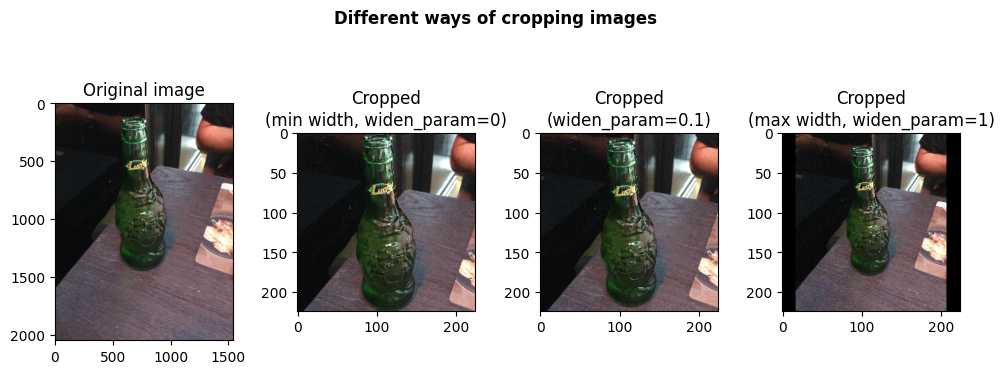

In [ ]:
fig, axes = plt.subplots(1,4,figsize = (10,4))

axes = axes.flatten()

axes[0].imshow(show_annotation_image(annotation_id=1, annotations=annotdata))
axes[0].set_title("Original image")

axes[1].imshow(try_square_crop(annotation_id=1, annotations=annotdata, widen_param=0, newsize=224))
axes[1].set_title("Cropped\n(min width, widen_param=0)")

axes[2].imshow(try_square_crop(annotation_id=1, annotations=annotdata, widen_param=0.1, newsize=224))
axes[2].set_title("Cropped\n(widen_param=0.1)")

axes[3].imshow(try_square_crop(annotation_id=1, annotations=annotdata, widen_param=1, newsize=224))
axes[3].set_title("Cropped\n(max width, widen_param=1)")

fig.suptitle("Different ways of cropping images", fontsize=12, fontweight ="bold")
plt.tight_layout(rect=[0, 0, 0.98, 0.98])
plt.show()

### Create image mask

The function below has two steps:

* It converts the annotation into a new image (_a mask_) showing the contours of the annotation (not the bounding box). This was adapted from a function written by Dr. Sreenivas Bhattiprolu ([link to GitHub](https://github.com/bnsreenu/python_for_microscopists/blob/master/335%20-%20Converting%20COCO%20JSON%20annotations%20to%20labeled%20mask%20images/335d-convert_coco_to_labeled_masks.py)).
* Then, it crops the resulting mask image in exactly the same way as the function described above (try_square_crop).

By using these two functions, each processed image will have its equivalent mask image that exactly mirrors the original image in terms of where the object is located.

In [ ]:
import skimage

In [ ]:
def mask_and_square_crop(annotation_id, annotations, widen_param, newsize):
    """
    Function to create binary mask for each annotation, resized according to the same criteria
    found in the 'try_square_crop' function.

    Parameters:
    - annotation_id (int): The ID of the annotation.
    - annotations (dict): The dictionary containing annotations data.
    - widen_param (float): The parameter to adjust square widening (0 to 1).
    - newsize (int): The desired size of the square image.

    Returns:
    - numpy.ndarray: The resized square binary mask image with borders added if necessary.
    """

    # Fix parameter if a value bigger than 1 is provided
    widen_param = min(1, widen_param)

    # Get image id for the selected annotation
    image_id = next(annot["image_id"] for annot in annotdata['annotations'] if annot["id"] == annotation_id)

    # Get image location
    image_filename = next(img["file_name"] for img in annotdata['images'] if img["id"] == image_id)
    image_location = os.path.join(dataset_path, image_filename)

    # Get image
    image_to_crop = cv2.imread(image_location)
    image_to_crop = cv2.cvtColor(image_to_crop, cv2.COLOR_BGR2RGB)

    # Get image dimensions
    raw_ymax, raw_xmax, _ = image_to_crop.shape

    # Get segmentation
    seg = next(annot["segmentation"] for annot in annotations['annotations'] if annot["id"] == annotation_id)[0]

    # Create mask
    mask_np = np.zeros((image_to_crop.shape[0], image_to_crop.shape[1]), dtype=np.uint16)
    rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
    mask_np[rr, cc] = 1

    # Get bbox for image
    annotation_bbox = next(annot["bbox"] for annot in annotations['annotations'] if annot["id"] == annotation_id)
    square_side = max(annotation_bbox[2], annotation_b


We demsonstrate how this function works below, using the same source image.

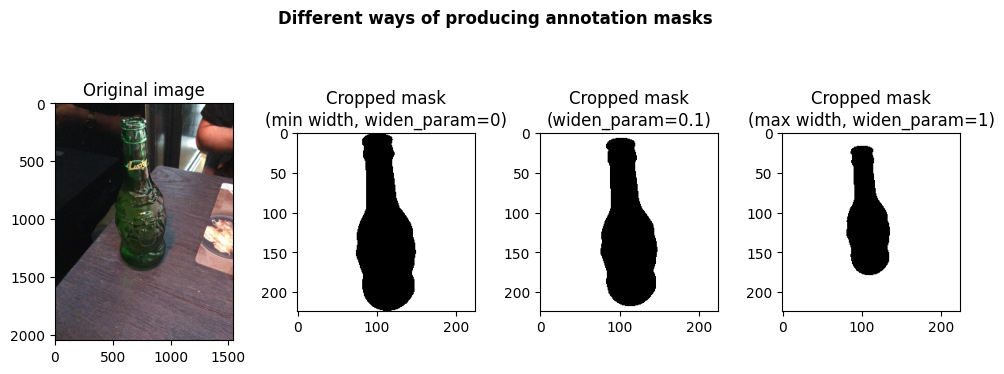

In [ ]:
fig, axes = plt.subplots(1,4,figsize = (10,4))

axes = axes.flatten()

axes[0].imshow(show_annotation_image(annotation_id=1, annotations=annotdata), cmap="Greys")
axes[0].set_title("Original image")

axes[1].imshow(mask_and_square_crop(annotation_id=1, annotations=annotdata, widen_param=0, newsize=224), cmap="Greys")
axes[1].set_title("Cropped mask\n(min width, widen_param=0)")

axes[2].imshow(mask_and_square_crop(annotation_id=1, annotations=annotdata, widen_param=0.1, newsize=224), cmap="Greys")
axes[2].set_title("Cropped mask\n(widen_param=0.1)")

axes[3].imshow(mask_and_square_crop(annotation_id=1, annotations=annotdata, widen_param=1, newsize=224), cmap="Greys")
axes[3].set_title("Cropped mask\n(max width, widen_param=1)")

fig.suptitle("Different ways of producing annotation masks", fontsize=12, fontweight ="bold")
plt.tight_layout(rect=[0, 0, 0.98, 0.98])
plt.show()

## 3) Average images by class

The function below blends multiple images to produce an 'average' image. It was adapted from code published on [Stack Overflow](https://stackoverflow.com/questions/57723968/blending-multiple-images-with-opencv).

In [ ]:
def blend(list_images):

    equal_fraction = 1.0 / (len(list_images))

    output = np.zeros_like(list_images[0])

    for img in list_images:
        output = output + img * equal_fraction

    output = output.astype(np.uint8)
    return output

We proceed to blend a random selection of 25 images from the five categories used in the first classification problem, and from the two categories used in the second classification problem. With a high number of images (e.g. over 100), the blended averages are difficult to interpret.

Even with 25 images, we cannot clearly distinguish the shape of an average class (for example, an average can or an average bottle). This is because the source images are very heterogeneous. First of all, not all cans or bottles are exactly the same. Furthermore, the scale is different across images (e.g. 10 pixels = 1cm in one image, and 10 pixels = 5cm in another). Finally, objects are not always rotated in the same way across pictures. In one picture, a bottle might be upright and in another it might be lying horizontally.

In [ ]:
c1_images_to_blend = annot_df.groupby('c1_label', group_keys=False).apply(lambda x: x.sample(25, random_state=1))[["id","c1_label"]].reset_index(drop=True)

In [ ]:
sample_images_a = [try_square_crop(idx, annotations=annotdata, widen_param=0.05, newsize=224) for idx in list(c1_images_to_blend.loc[c1_images_to_blend.c1_label=="Plastic film","id"])]
sample_images_b = [try_square_crop(idx, annotations=annotdata, widen_param=0.05, newsize=224) for idx in list(c1_images_to_blend.loc[c1_images_to_blend.c1_label=="Bottle","id"])]
sample_images_c = [try_square_crop(idx, annotations=annotdata, widen_param=0.05, newsize=224) for idx in list(c1_images_to_blend.loc[c1_images_to_blend.c1_label=="Carton","id"])]
sample_images_d = [try_square_crop(idx, annotations=annotdata, widen_param=0.05, newsize=224) for idx in list(c1_images_to_blend.loc[c1_images_to_blend.c1_label=="Can","id"])]
sample_images_e = [try_square_crop(idx, annotations=annotdata, widen_param=0.05, newsize=224) for idx in list(c1_images_to_blend.loc[c1_images_to_blend.c1_label=="Cup","id"])]

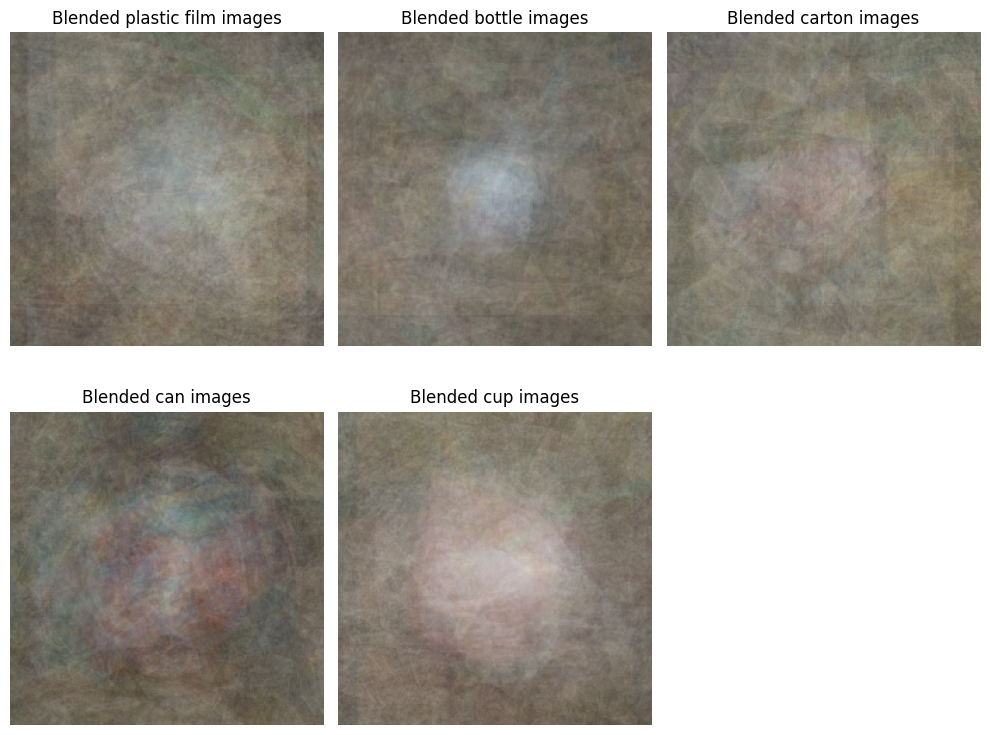

In [ ]:
plt.rcParams["figure.figsize"] = [10,8]
plt.rcParams["figure.autolayout"] = True

plt.subplot(2, 3, 1)
plt.imshow(blend(sample_images_a))
plt.axis('off')
plt.title("Blended plastic film images")

plt.subplot(2, 3, 2)
plt.imshow(blend(sample_images_b))
plt.axis('off')
plt.title("Blended bottle images")

plt.subplot(2, 3, 3)
plt.imshow(blend(sample_images_c))
plt.axis('off')
plt.title("Blended carton images")

plt.subplot(2, 3, 4)
plt.imshow(blend(sample_images_d))
plt.axis('off')
plt.title("Blended can images")

plt.subplot(2, 3, 5)
plt.imshow(blend(sample_images_e))
plt.axis('off')
plt.title("Blended cup images")

plt.show()

plt.rcParams.update(plt.rcParamsDefault)

Similarly, we cannot distinguish average shapes or features of the average plastic or glass bottle.

In [ ]:
c2_images_to_blend = annot_df.groupby('c2_label', group_keys=False).apply(lambda x: x.sample(10, random_state=1))[["id","c2_label"]].reset_index(drop=True)

In [ ]:
sample_images_f = [try_square_crop(idx, annotations=annotdata, widen_param=0.05, newsize=224) for idx in list(c2_images_to_blend.loc[c2_images_to_blend.c2_label=="Plastic","id"])]
sample_images_g = [try_square_crop(idx, annotations=annotdata, widen_param=0.05, newsize=224) for idx in list(c2_images_to_blend.loc[c2_images_to_blend.c2_label=="Glass","id"])]

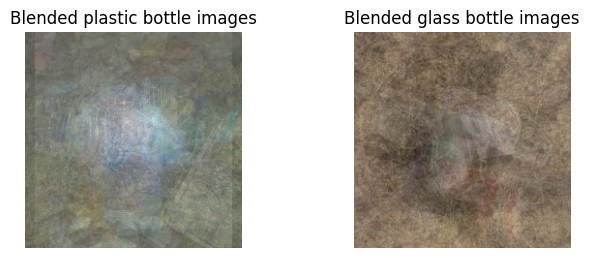

In [ ]:
plt.rcParams["figure.figsize"] = [10,5]
plt.rcParams["figure.autolayout"] = True

plt.subplot(2, 3, 1)
plt.imshow(blend(sample_images_f))
plt.axis('off')
plt.title("Blended plastic bottle images")

plt.subplot(2, 3, 2)
plt.imshow(blend(sample_images_g))
plt.axis('off')
plt.title("Blended glass bottle images")

plt.show()

plt.rcParams.update(plt.rcParamsDefault)

## 4) Selecting samples for machine learning models

### Selecting samples for model C1

Based on our exploratory analysis, we restrict our classification task for analysis C.1 to the following objects:

* Bottles
* Cartons
* Cups
* Cans
* Plastic film

This set of objects meet the following criteria, as informed by our exploratory data analysis:

* They are sufficiently distinct from each other in terms of shape, meaning they will be easier to classify.
* They exist in sufficient numbers in the dataset, suggesting that they are commonly found in real-life scenarios and that we will have enough samples in our traning, validation and testing sets.
* They have relatively similar real-life sizes, meaning that if we crop the images around the annotation bounding box we will not introduce too much size distortion.


This results in 1,561 total usable annotations. The variables useful for classification, including the labels and image and annotation id's are stored in DataFrame 'annot_df_c1'.

In [ ]:
#Select a subset of the data
annot_df_c1 = annot_df.dropna(subset=['c1_label'], inplace=False)
annot_df_c1.reset_index(drop=True, inplace=True)
annot_df_c1.shape

(1561, 17)

In [ ]:
#Only keep the relevant columns
annot_df_c1 = annot_df_c1[["id","image_id","category_id","c1_numlabel","c1_label","bbox_pct","scene_category"]].copy()

Some of our 1,561 annotations are in fact in the same image. For example, 340 images contain two different annotations. However, if we use our image cropping approach around each annotation bounding box, we can treat each of these as separate images.

In [ ]:
annot_df_c1["annotations_by_image"] = annot_df_c1.groupby('image_id')['id'].transform('count')
annot_df_c1["annotations_by_image"].value_counts()[:5]

1    638
2    340
3    165
6     90
4     88
Name: annotations_by_image, dtype: int64

For this classification problem, we choose a widen_param of 0.05 - this results in a close crop around the annotation bounding box but retains a small amount of backround elements as shown below.

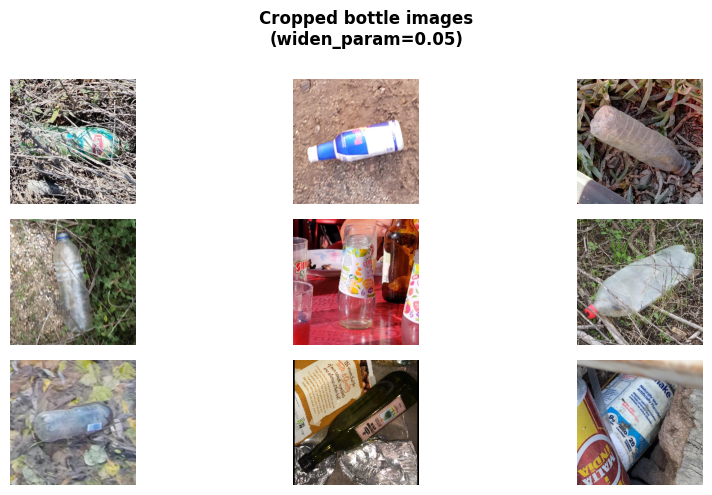

In [ ]:
annotations_samples = sample(list(annot_df_c1.loc[annot_df_c1.c1_label=="Bottle","id"]), 9)

fig, axes = plt.subplots(3,3,figsize = (10,5))

for (annotindex, ax) in zip(annotations_samples,axes.flatten()):

  ax.imshow(try_square_crop(annotindex, annotations=annotdata, widen_param=0.05, newsize=224))
  ax.set_axis_off()

fig.suptitle("Cropped bottle images\n(widen_param=0.05)", fontsize=12, fontweight ="bold")
plt.tight_layout(rect=[0, 0, 0.98, 0.98])
plt.show()

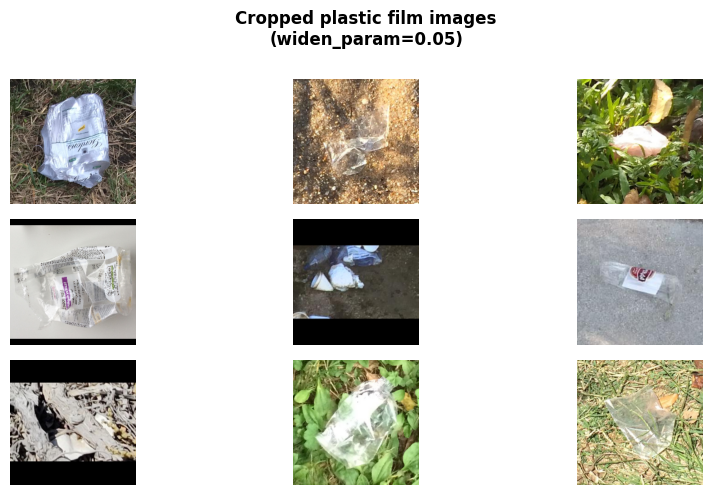

In [ ]:
annotations_samples = sample(list(annot_df_c1.loc[annot_df_c1.c1_label=="Plastic film","id"]), 9)

fig, axes = plt.subplots(3,3,figsize = (10,5))

for (annotindex, ax) in zip(annotations_samples,axes.flatten()):

  ax.imshow(try_square_crop(annotindex, annotations=annotdata, widen_param=0.05, newsize=224))
  ax.set_axis_off()

fig.suptitle("Cropped plastic film images\n(widen_param=0.05)", fontsize=12, fontweight ="bold")
plt.tight_layout(rect=[0, 0, 0.98, 0.98])
plt.show()

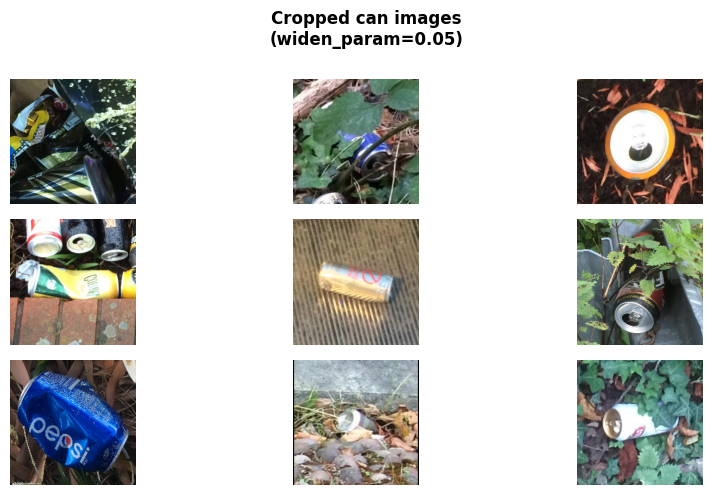

In [ ]:
annotations_samples = sample(list(annot_df_c1.loc[annot_df_c1.c1_label=="Can","id"]), 9)

fig, axes = plt.subplots(3,3,figsize = (10,5))

for (annotindex, ax) in zip(annotations_samples,axes.flatten()):

  ax.imshow(try_square_crop(annotindex, annotations=annotdata, widen_param=0.05, newsize=224))
  ax.set_axis_off()

fig.suptitle("Cropped can images\n(widen_param=0.05)", fontsize=12, fontweight ="bold")
plt.tight_layout(rect=[0, 0, 0.98, 0.98])
plt.show()

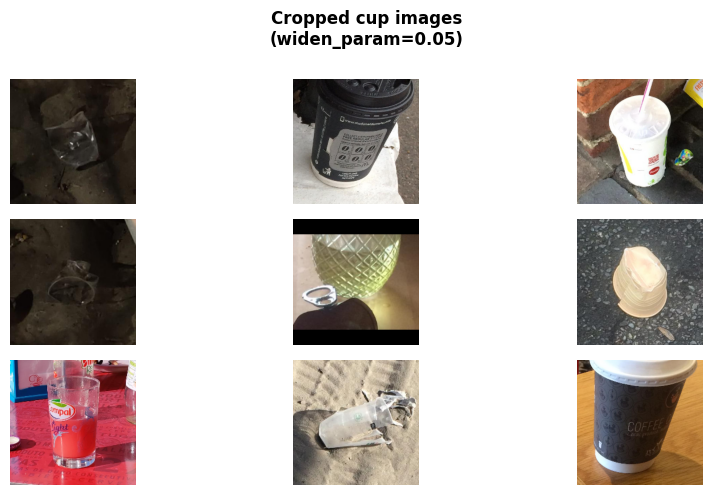

In [ ]:
annotations_samples = sample(list(annot_df_c1.loc[annot_df_c1.c1_label=="Cup","id"]), 9)

fig, axes = plt.subplots(3,3,figsize = (10,5))

for (annotindex, ax) in zip(annotations_samples,axes.flatten()):

  ax.imshow(try_square_crop(annotindex, annotations=annotdata, widen_param=0.05, newsize=224))
  ax.set_axis_off()

fig.suptitle("Cropped cup images\n(widen_param=0.05)", fontsize=12, fontweight ="bold")
plt.tight_layout(rect=[0, 0, 0.98, 0.98])
plt.show()

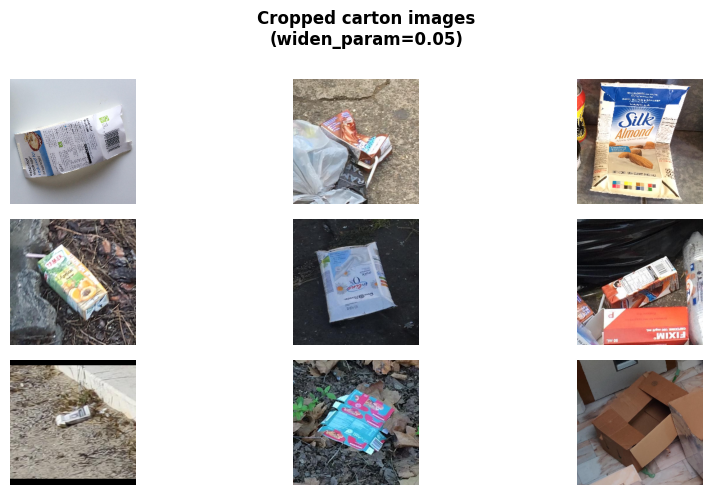

In [ ]:
annotations_samples = sample(list(annot_df_c1.loc[annot_df_c1.c1_label=="Carton","id"]), 9)

fig, axes = plt.subplots(3,3,figsize = (10,5))

for (annotindex, ax) in zip(annotations_samples,axes.flatten()):

  ax.imshow(try_square_crop(annotindex, annotations=annotdata, widen_param=0.05, newsize=224))
  ax.set_axis_off()

fig.suptitle("Cropped carton images\n(widen_param=0.05)", fontsize=12, fontweight ="bold")
plt.tight_layout(rect=[0, 0, 0.98, 0.98])
plt.show()

### Selecting samples for model C2

For our second classification task C.2, we will simply select the bottles in task C.1 and differentiate between glass and plastic bottles. The variables useful for classification, including the labels and image and annotation id's are stored in DataFrame 'annot_df_c2'.

In [ ]:
#Select a subset of the data
annot_df_c2 = annot_df.dropna(subset=['c2_label'], inplace=False)
annot_df_c2.reset_index(drop=True, inplace=True)
annot_df_c2.shape

(438, 17)

In [ ]:
#Only keep the relevant columns
annot_df_c2 = annot_df_c2[["id","image_id","c2_numlabel","c2_label","bbox_pct","scene_category"]].copy()

### Selecting samples for model S1

For our image segmentation task, we will once again focus on images of bottles. However, we will only work with images that have a single bottle. This leaves us with 248 images.

In [ ]:
annot_df_s1 = annot_df.loc[annot_df["supercategory"].isin(["Bottle"]),:]

In [ ]:
annot_df_s1 = annot_df_s1[["id","image_id","category_id","bbox_pct","scene_category"]].copy()
annot_df_s1["annotations_by_image"] = annot_df_s1.groupby('image_id')['id'].transform('count')
annot_df_s1 = annot_df_s1.loc[annot_df_s1.annotations_by_image==1,:].copy()

In [ ]:
annot_df_s1.reset_index(drop=True, inplace=True)
annot_df_s1.shape

(248, 6)

### Saving classification labels

In [ ]:
np.savez("{}/{}".format(features_path,"classification-labels.npz"), c1=annot_df_c1, c2=annot_df_c2, s1=annot_df_s1,
         c1_colnames=annot_df_c1.columns, c2_colnames=annot_df_c2.columns, s1_colnames=annot_df_s1.columns)

## 5) Process images for machine learning models

Finally, we process the images we will use in our classification and segmentation tasks. As a reminder:

* For our classification tasks, this means resizing and cropping the images in a square around the annotation bounding box and, if necessary, adding a black border.
* On top of the above, for our segmentation task, we also need to produce image masks that mirror exactly the same transformations applied to the original images.

We do this for five values of the *widen_param* parameter, so we can perform sensitivity analyses in our machine learning tasks if needed.

The loop below can take a long time to run, and uses a lot of memory. We ran it on Google Colab using a hardware accelerator in just under 3 hours.

In [1]:
for width in [0, 0.05, 0.2, 0.5, 1]:

  #Generate images for task C1, and store as a 4-dimensional numpy array
  c1_data = [try_square_crop(idx, annotations=annotdata, widen_param=width, newsize=224) for idx in list(annot_df_c1.id)]
  c1_data = np.stack(c1_data, axis=0)

  #Find the locations (indices) of images for task C2 within the set prepared for task C1 (C2 is a subset of C1)
  #And store those images is a separate 4-dimensional numpy array
  c2_locations_in_c1 = annot_df_c2["id"].map(lambda x: np.squeeze(annot_df_c1.index[annot_df_c1.id==x]))
  c2_data = c1_data[c2_locations_in_c1,:,:,:]

  #Find the locations (indices) of images for task S1 within the set prepared for task C1 (S1 is also a subset of C1)
  #And store those images is a separate 4-dimensional numpy array
  s1_locations_in_c1 = annot_df_s1["id"].map(lambda x: np.squeeze(annot_df_c1.index[annot_df_c1.id==x]))
  s1_data = c1_data[s1_locations_in_c1,:,:,:]

  #Create binary image masks for images used in task S1
  #And store those images is a separate 4-dimensional numpy array
  s1_masks = [mask_and_square_crop(idx, annotations=annotdata, widen_param=width, newsize=224) for idx in list(annot_df_s1.id)]
  s1_masks = np.stack(s1_masks, axis=0)

  #Create folder to store the transformed images and masks
  destination = "{}/{}".format(features_path,"widen_param_{}".format(width))

  if not os.path.exists(destination):
    os.mkdir(destination)

  #Save data
  np.savez("{}/{}".format(destination,"classification-images.npz"), c1=c1_data, c2=c2_data, s1=s1_data, s1_masks=s1_masks)